<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Решающее дерево</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Подготовка

Импортируем нужные библиотеки

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
warnings.filterwarnings('ignore')

Загрузим данные

In [2]:
# загружаем данные и сохраняем в переменной taxi
taxi = pd.read_csv("/datasets/taxi.csv")

In [3]:
# смотрим информацию о таблице
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Изменим тип данных datetime с object на datetime64. Установим индекс таблицы равным столбцу datetime. Отсортируем индекс таблицы.

In [4]:
# меняем тип данных
# устанавляваем индексы
# сортируем таблицу
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Итак есть данные о заказах такси в аэропорты в период с 1 марта по 31 августа 2018 года. Посмотрим на первые 10 значений таблицы.

In [5]:
# смотрим первые 10 строк таблицы
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Видно, что интервал между значениями ряда постоянный: 10 минут.

Выполним их ресемплирование по одному часу. В каждой группе вычисляем агрегированное значение ряда. В нашем случае - сумма заказов.

Text(0, 0.5, 'Число заказов')

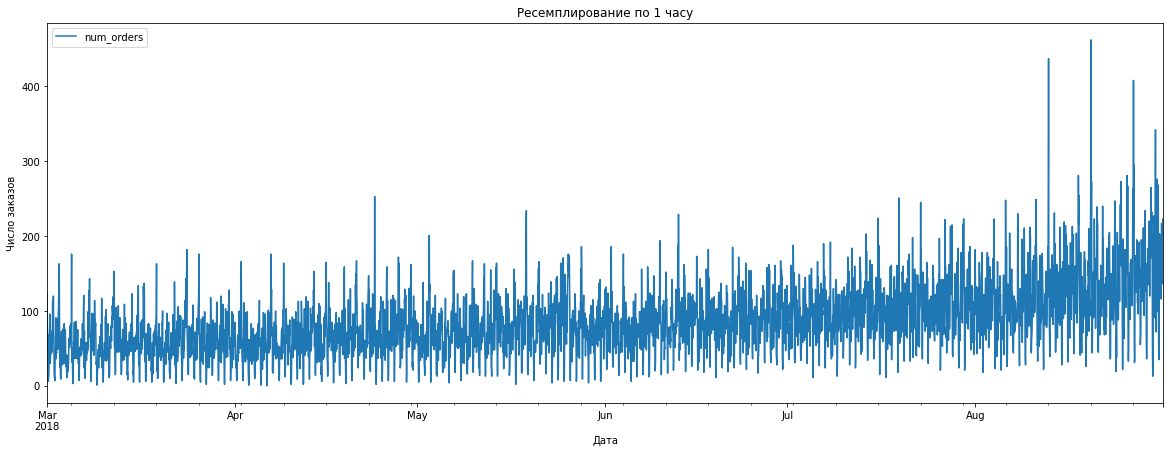

In [6]:
# проризводим ресемплирование по одному часу
taxi = taxi.resample('1H').sum()
taxi.plot(figsize=(20,7))
plt.title('Ресемплирование по 1 часу')
plt.xlabel('Дата')
plt.ylabel('Число заказов')

Заметны выбросы в последние 2 недели.

Для определения стационарности временного ряда найдём скользящее среднее и стандартное скользящее отклонение.

Text(0, 0.5, 'Число заказов')

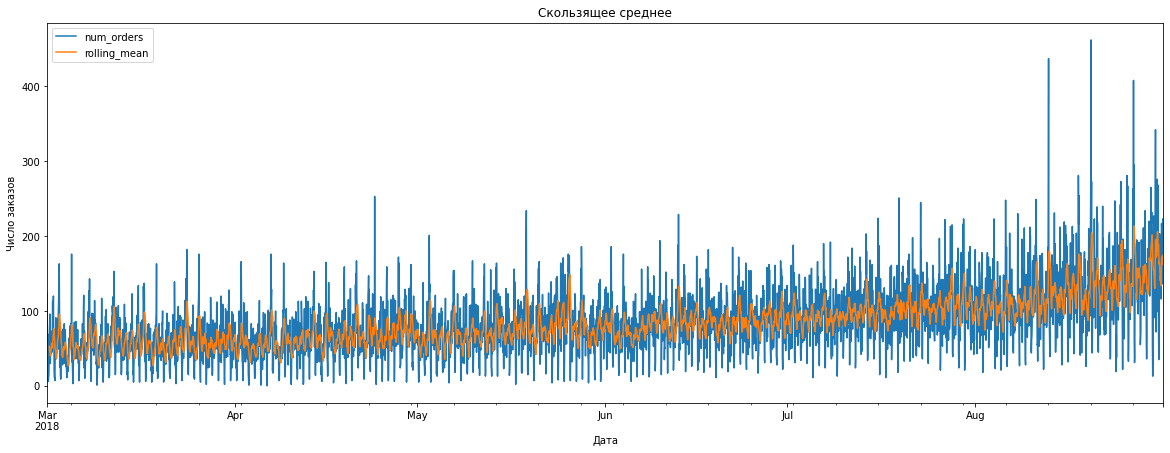

In [7]:
# найдём скользящее среднее
taxi_2 = taxi.copy()
taxi_2['rolling_mean'] = taxi.rolling(10).mean()
taxi_2.plot(figsize=(20,7))
plt.title('Скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Число заказов')

Text(0, 0.5, 'Число заказов')

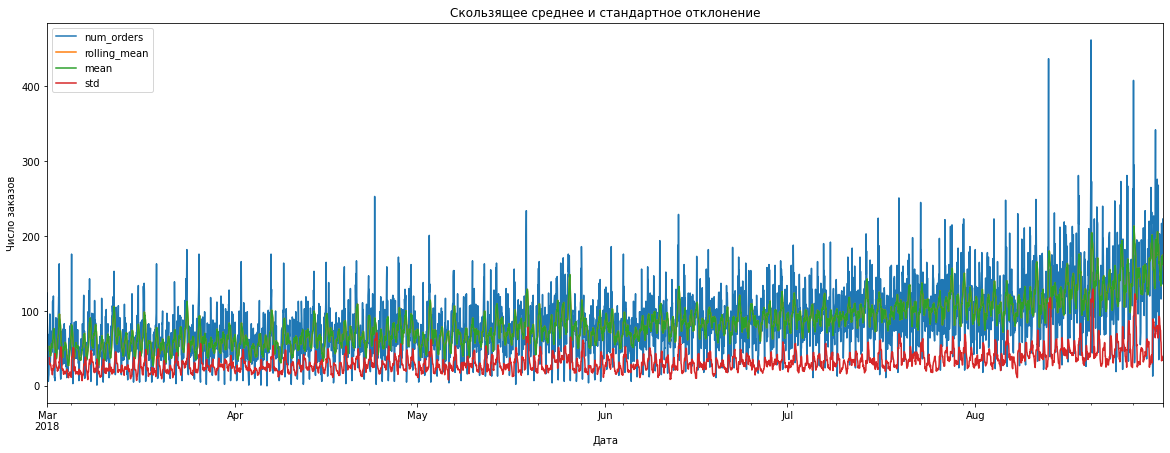

In [8]:
# стандартное скользящее отклонение
taxi_2['mean'] = taxi_2['num_orders'].rolling(10).mean()
taxi_2['std'] = taxi_2['num_orders'].rolling(10).std()
taxi_2.plot(figsize=(20,7)) 
plt.title('Скользящее среднее и стандартное отклонение')
plt.xlabel('Дата')
plt.ylabel('Число заказов')

Временной ряд не стационарный, т.к со временем у него меняется среднее значение и стандартное отклонение.

Для потверждения заключения проведём тест Дикки-Фуллера.

In [9]:
# проводим тест Дикки - Фуллера
p_value = adfuller(taxi['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Ряд нестационарен по критерию Дики-Фуллера')

P = 0.028940051402612906
Ряд стационарен по критерию Дики-Фуллера


**Вывод**
* была открыта таблица с данными о заказах такси в аэропорты
* был изменён тип данных datetime с object на datetime64
* был установлен индекс таблицы равным столбцу datetime
* было произведено ресемплирование по 1 часу
* были построены графики изменения стандартного отклонение и сеользящего среднего
* на основе графиков было сделано заключение, что ряд не стационарен
* был проведён тест Дики-Фуллера и он показал, что ряд стационарен (возможно из-за большого периода без тренда и одинаковой дисперсии)

## Анализ

Посмотрим на данные за последнеи 2 недели.

Text(0, 0.5, 'Число заказов')

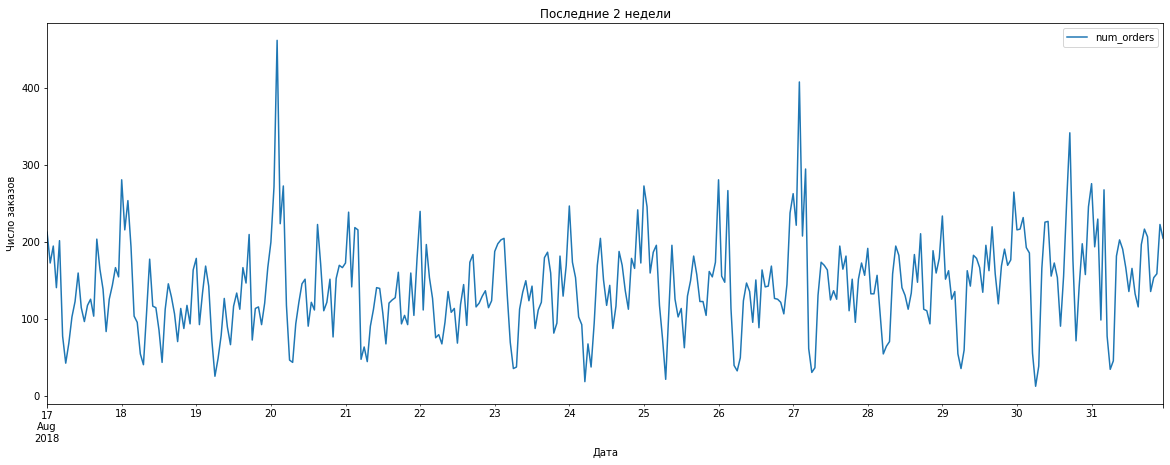

In [10]:
# смотрим данные за последние 2 недели
taxi['2018-08-17':'2018-08-31'].plot(figsize=(20,7))
plt.title('Последние 2 недели')
plt.xlabel('Дата')
plt.ylabel('Число заказов')

Есть явно выраженные пики 20 и 27 августа. Это странно, т.к. это был понедельник. Изучим по времени. Может быть пик приходился на ночной прилет самолетов.

Text(0, 0.5, 'Число заказов')

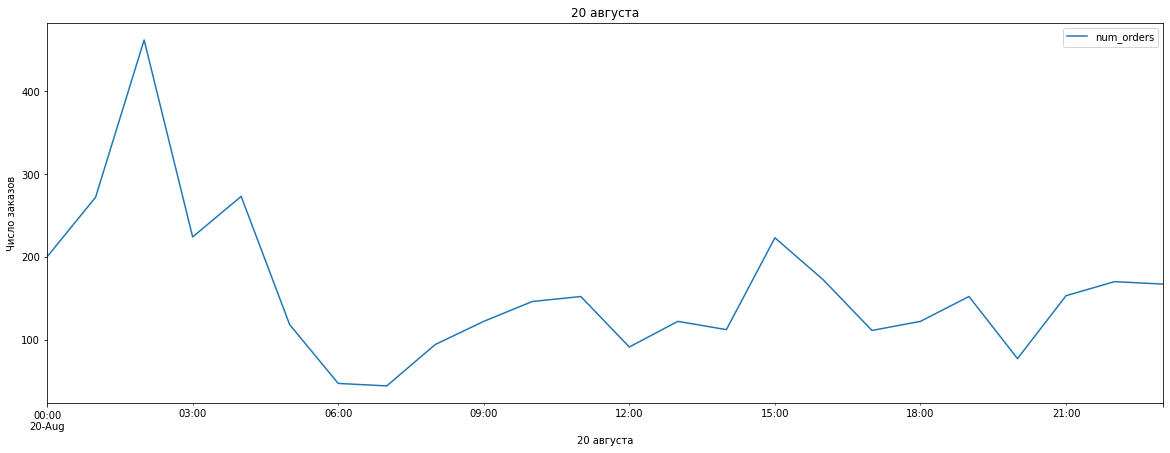

In [11]:
# смотрим данные за 20 августа 2018
taxi['2018-08-20':'2018-08-20'].plot(figsize=(20,7))
plt.title('20 августа')
plt.xlabel('20 августа')
plt.ylabel('Число заказов')

Text(0, 0.5, 'Число заказов')

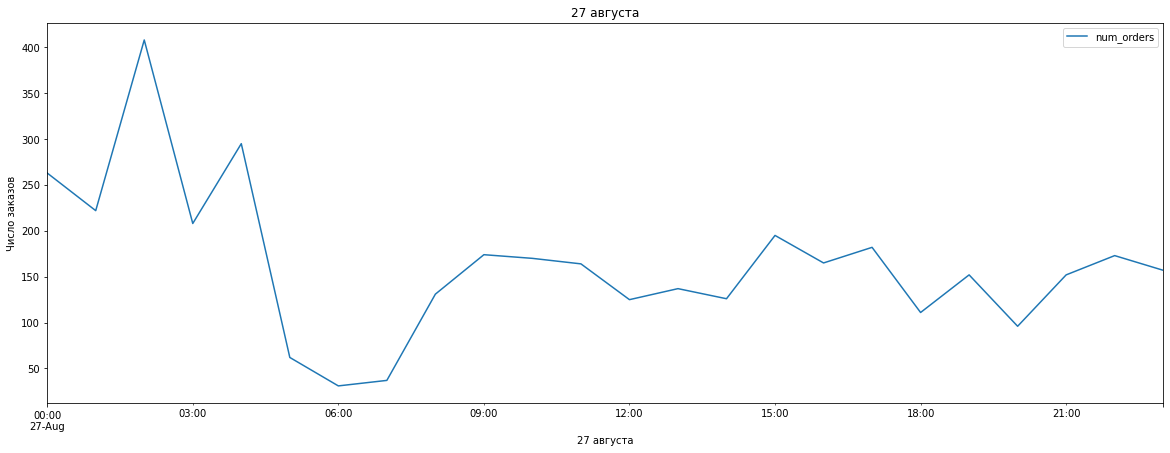

In [12]:
# смотрим данные за 27 августа 2018
taxi['2018-08-27':'2018-08-27'].plot(figsize=(20,7))
plt.title('27 августа')
plt.xlabel('27 августа')
plt.ylabel('Число заказов')

В обоих случаях пик приходится на 02.00 ночи. Значит действительно много людей возвращаются из отпуска вечерними рейсами в воскресение.

Изучим тренды и сезонность.

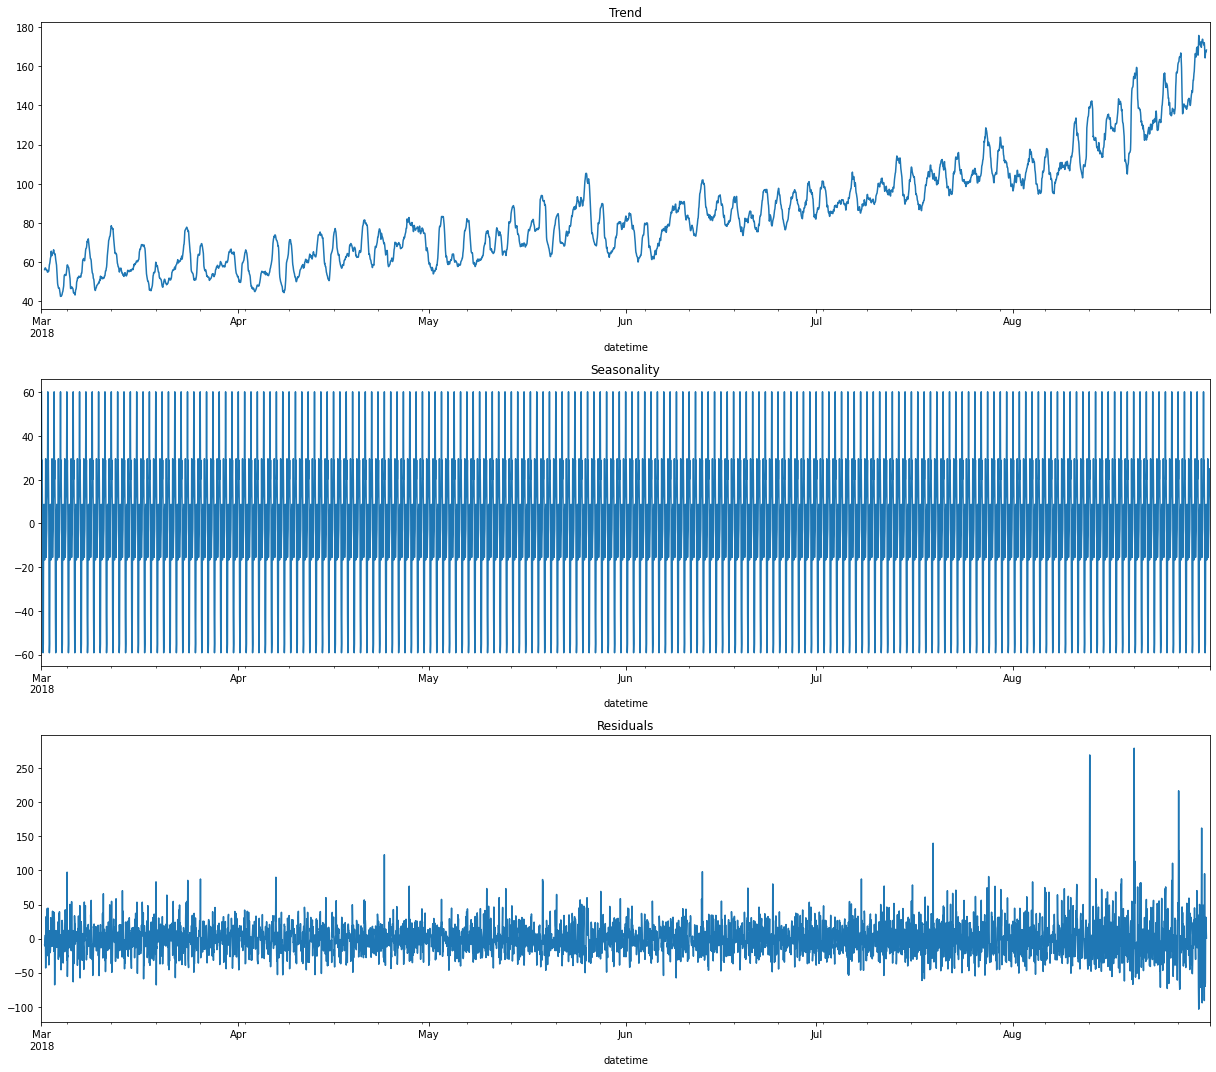

In [13]:
# изучаем тренды и сезонность
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(17,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд связан с временем года. В период отпусков(июль-август) число заказов растёт.

Посмотрим на последние 2 недели июля и августа.

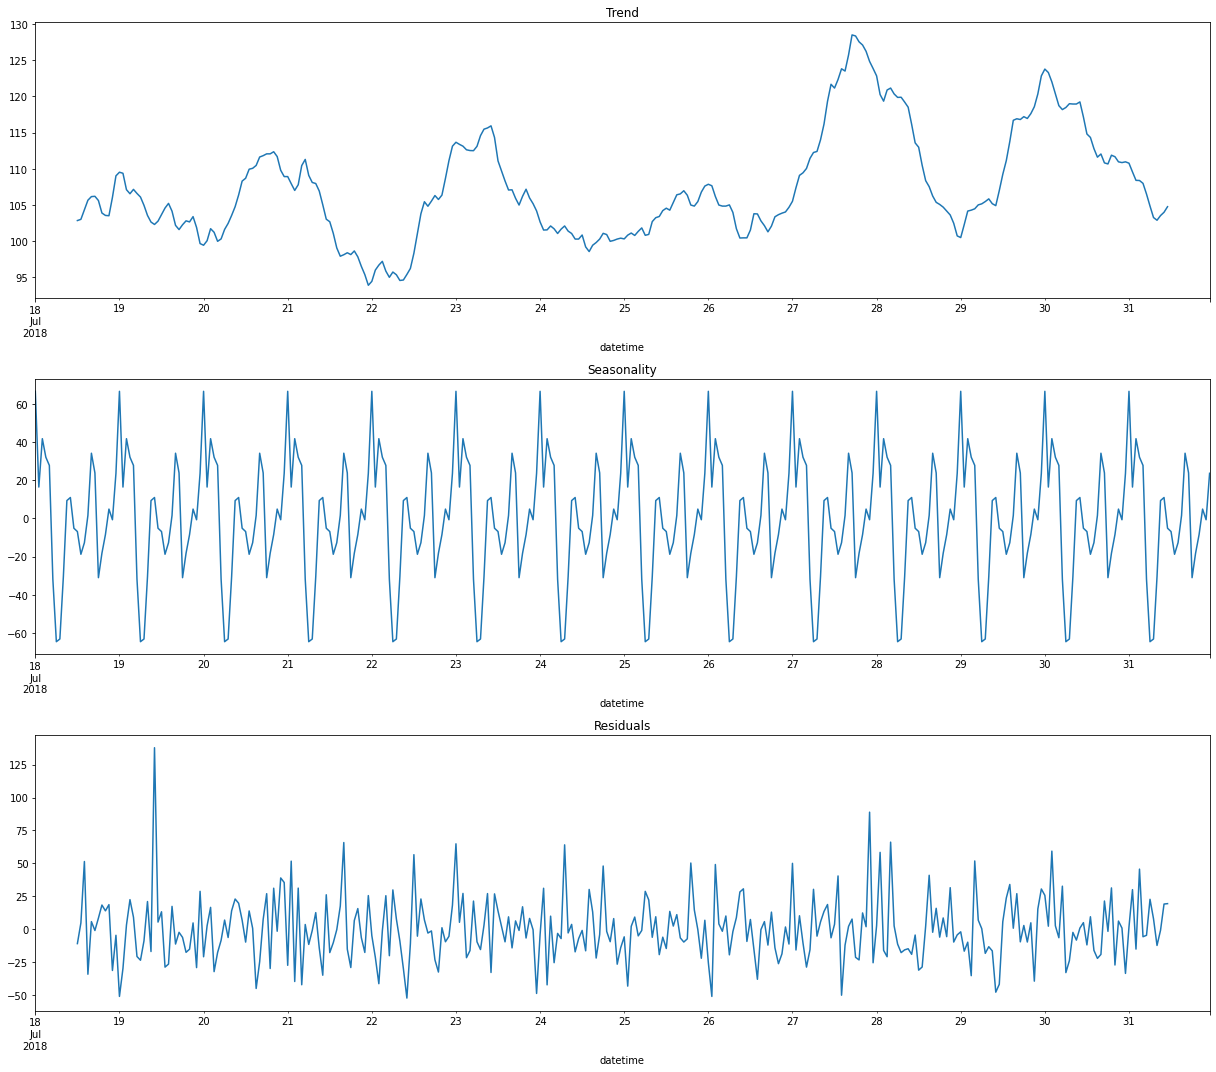

In [14]:
# смотрим последние 2 недели июля
decomposed = seasonal_decompose(taxi['2018-07-18':'2018-07-31'])
plt.figure(figsize=(17,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

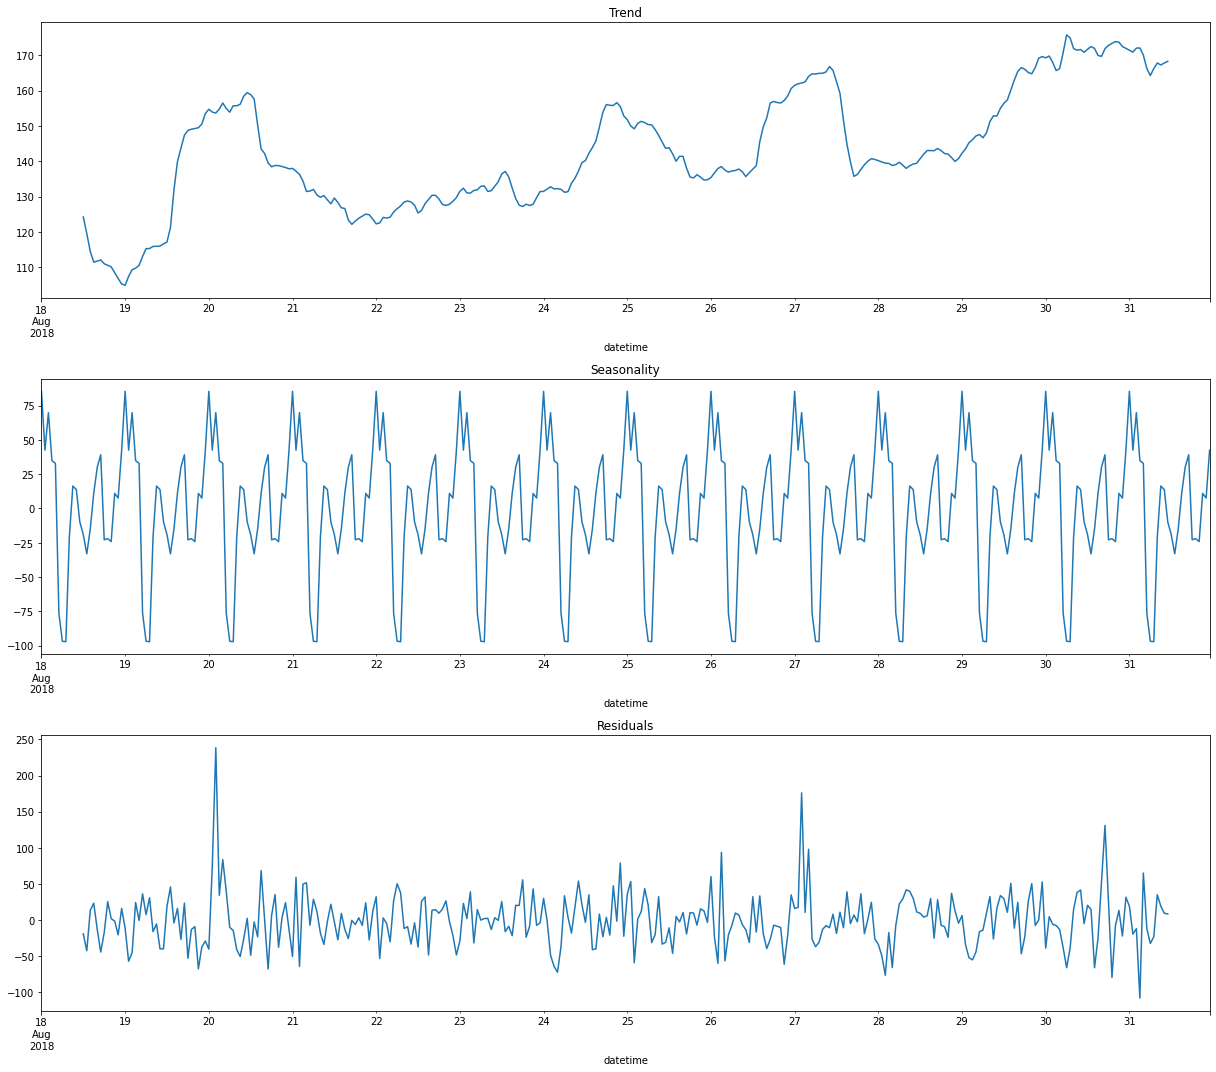

In [15]:
# смотрим последние 2 недели августа
decomposed = seasonal_decompose(taxi['2018-08-18':'2018-08-31'])
plt.figure(figsize=(17,15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд показывает, что к концу недели и в середине идет увеличение заказов.  Из месяца в месяц данные отличаются и носят цикличный характер. Добавим следующие признаки:

* dayofweek
* hour
* lag_1
* lag_2
* rolling_mean

Напишем функцию make_features(), чтобы добавить к таблице 5 новых календарных признака.

In [16]:
# пишем функцию
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)

    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(taxi, 2, 24)

In [17]:
taxi.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


**Вывод**
* был проведён анализ данных
* на основе проведенного анализа были добавлены 5 временных признака
 * день недели
 * час
 * lag_1
 * lag_2
 * скользящее среднее

## Обучение

Разобьём данные на обучающую и тестовую выборки. Укажем признаки и целевой признак.

In [18]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state=12345)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

### Решающее дерево

In [19]:
def cv_time_series_rmse(model, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        model.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, model.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [20]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 8

In [21]:
%%time

model_dtr = DecisionTreeRegressor() 
hyperparams = [{'max_depth':range (1, 25, 2),
                'min_samples_leaf': range (1, 25, 2),
                'random_state':[12345]}]

clf = GridSearchCV(model_dtr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Лучшие параметры:")
print()
best_params_DTR = clf.best_params_
print(best_params_DTR)
print()

Лучшие параметры:

{'max_depth': 11, 'min_samples_leaf': 13, 'random_state': 12345}

CPU times: user 7.65 s, sys: 40.3 ms, total: 7.69 s
Wall time: 7.72 s


In [22]:
%%time

model_dtr = DecisionTreeRegressor()
model_dtr.set_params(**best_params_DTR)
cv_RMSE_DTR = cv_time_series_rmse(model=model_dtr, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('RMSE решающего дерева =', cv_RMSE_DTR)

RMSE решающего дерева = 25.471846706371938
CPU times: user 71.4 ms, sys: 0 ns, total: 71.4 ms
Wall time: 73.5 ms


### CatBoostRegressor

In [23]:
%%time

model_cbr = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'iterations':[200],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(model_cbr, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
best_params_CBR = clf.best_params_
print(best_params_CBR)

{'iterations': 200, 'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
CPU times: user 5.91 s, sys: 318 ms, total: 6.23 s
Wall time: 17.1 s


In [24]:
%%time

model_cbr = CatBoostRegressor()
model_cbr.set_params(**best_params_CBR)
cv_RMSE_CBR = cv_time_series_rmse(model=model_cbr, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('RMSE для cbr =', cv_RMSE_CBR)

RMSE для cbr = 24.670765015466298
CPU times: user 1.48 s, sys: 51.2 ms, total: 1.53 s
Wall time: 4.4 s


### LGBMRegressor

In [25]:
%%time

model_lgbm = LGBMRegressor() 
hyperparams = [{'n_estimators': range (1, 19, 2), 
                'max_depth': range (1, 19, 2),
                'random_state':[12345]}]

clf = GridSearchCV(model_lgbm, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
best_params_LGBMR = clf.best_params_

Лучшие параметры:

{'max_depth': 11, 'n_estimators': 17, 'random_state': 12345}

CPU times: user 59.1 s, sys: 188 ms, total: 59.3 s
Wall time: 59.3 s


In [26]:
%%time

model_lgbm = LGBMRegressor()
model_lgbm.set_params(**best_params_LGBMR)
cv_RMSE_LGBMR = cv_time_series_rmse(model=model_lgbm, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('RMSE длч lgbm =', cv_RMSE_LGBMR)

RMSE длч lgbm = 26.083921979545966
CPU times: user 1.51 s, sys: 20.4 ms, total: 1.53 s
Wall time: 1.5 s


### LinearRegression

In [27]:
%%time

model_lr = LinearRegression()
cv_RMSE_LR = cv_time_series_rmse(model=model_lr, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('RMSE линейной регрессии =', cv_RMSE_LR)

RMSE линейной регрессии = 31.39317588929839
CPU times: user 57.1 ms, sys: 4.18 ms, total: 61.3 ms
Wall time: 125 ms


## Тестирование

### Линейная регрессия

RMSE: 51.268666988640035
CPU times: user 18.3 ms, sys: 3.86 ms, total: 22.2 ms
Wall time: 20.3 ms


Text(0, 0.5, 'Число заказов')

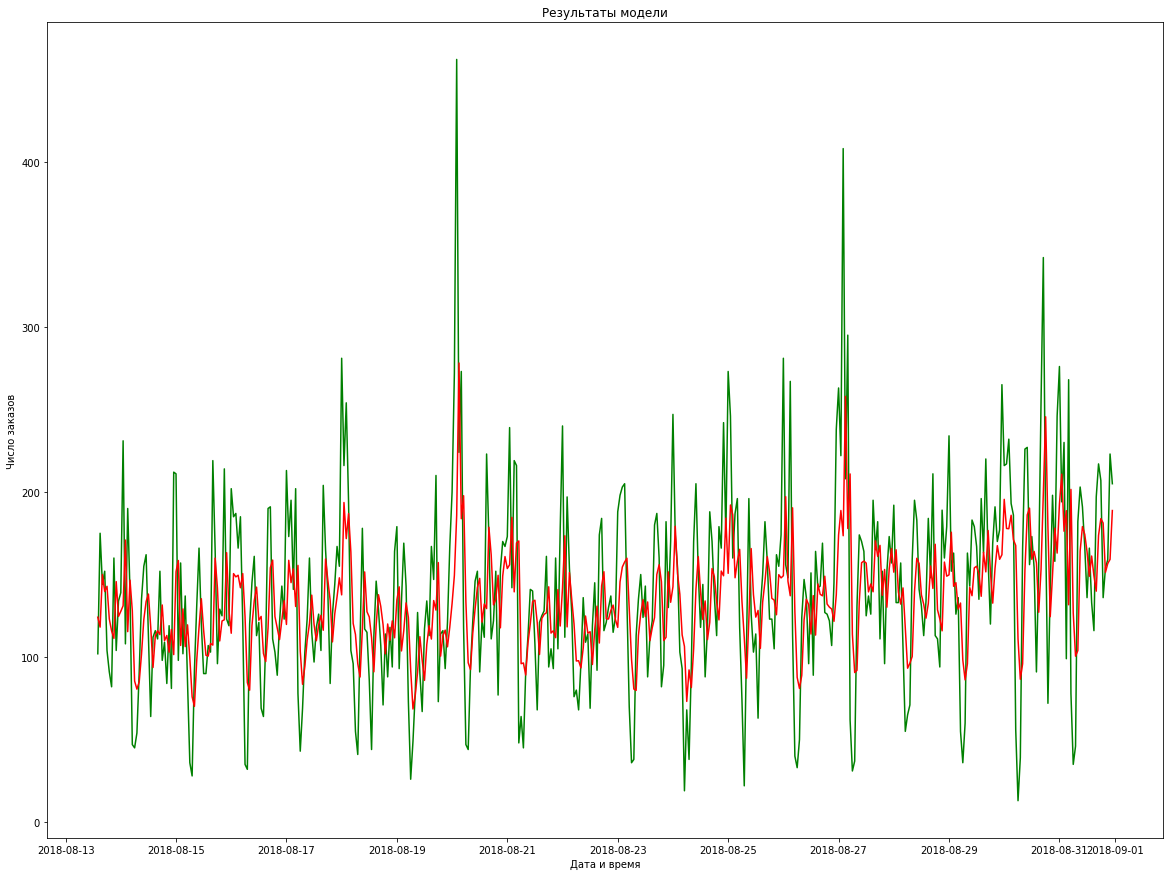

In [28]:
%%time
best_model = LinearRegression() 
best_model.fit(train_features, train_target)
test_predictions = best_model.predict(test_features)
print('RMSE:', mean_squared_error(test_target, test_predictions) ** 0.5)

plt.figure(figsize=(20,15))
plt.plot(test_target.index, 
         test_target, 
         'g-', 
         test_target.index, 
         test_predictions,
         'r-')
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

### LGBMRegressor

RMSE: 53.72050806604553
CPU times: user 298 ms, sys: 264 µs, total: 298 ms
Wall time: 262 ms


Text(0, 0.5, 'Число заказов')

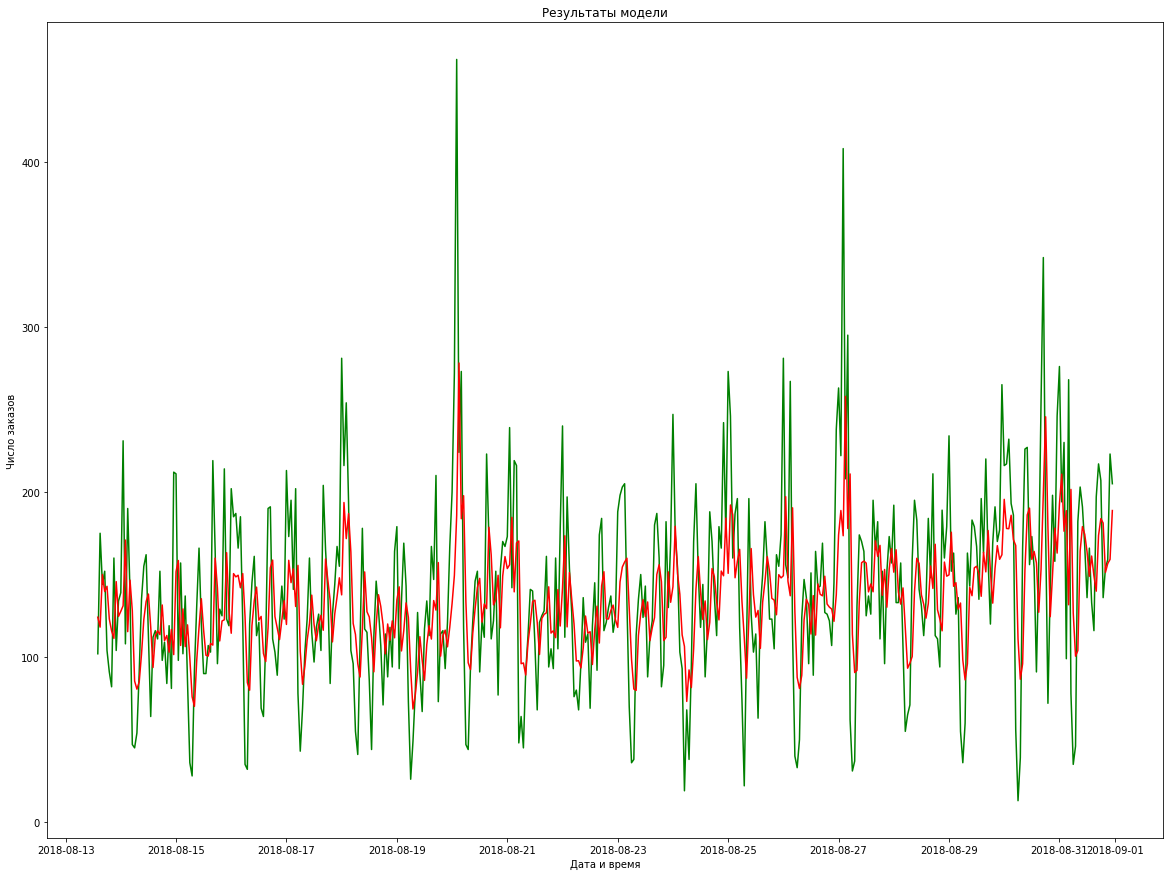

In [29]:
%%time
best_model_lgbmr = LGBMRegressor(**best_params_LGBMR)
best_model_lgbmr.fit(train_features, train_target)
test_predictions_lgbmr = best_model_lgbmr.predict(test_features)
print('RMSE:', mean_squared_error(test_target, test_predictions_lgbmr) ** 0.5)

plt.figure(figsize=(20,15))
plt.plot(test_target.index, 
         test_target, 
         'g-', 
         test_target.index, 
         test_predictions,
         'r-')
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

### CatBoostRegressor

RMSE: 45.83627474289359
CPU times: user 246 ms, sys: 20.4 ms, total: 266 ms
Wall time: 670 ms


Text(0, 0.5, 'Число заказов')

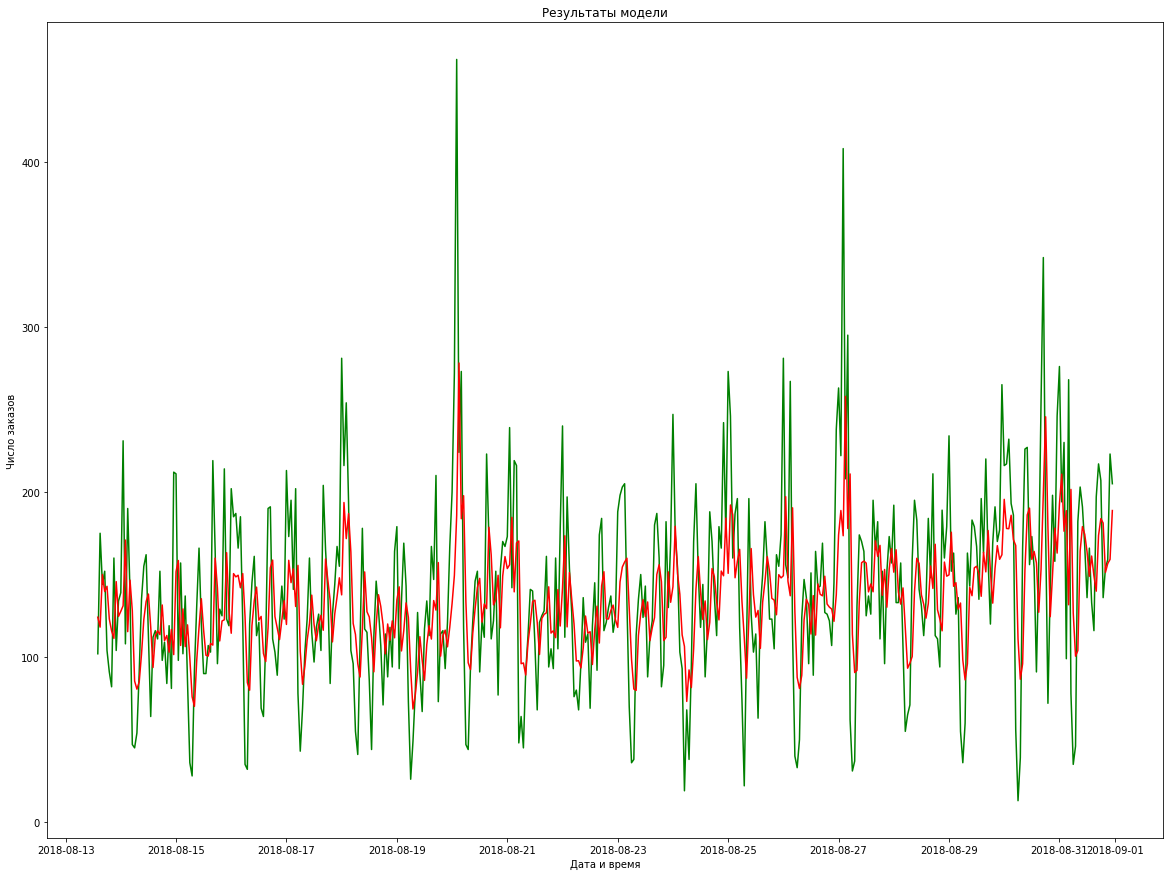

In [30]:
%%time
best_model_cbr = CatBoostRegressor(**best_params_CBR) 
best_model_cbr.fit(train_features, train_target)
test_predictions_cbr = best_model_cbr.predict(test_features)
print('RMSE:', mean_squared_error(test_target, test_predictions_cbr) ** 0.5)

plt.figure(figsize=(20,15))
plt.plot(test_target.index, 
         test_target, 
         'g-', 
         test_target.index, 
         test_predictions,
         'r-')
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

### Решающее дерево

RMSE: 53.94394269525368
CPU times: user 27.6 ms, sys: 3.72 ms, total: 31.3 ms
Wall time: 38.9 ms


Text(0, 0.5, 'Число заказов')

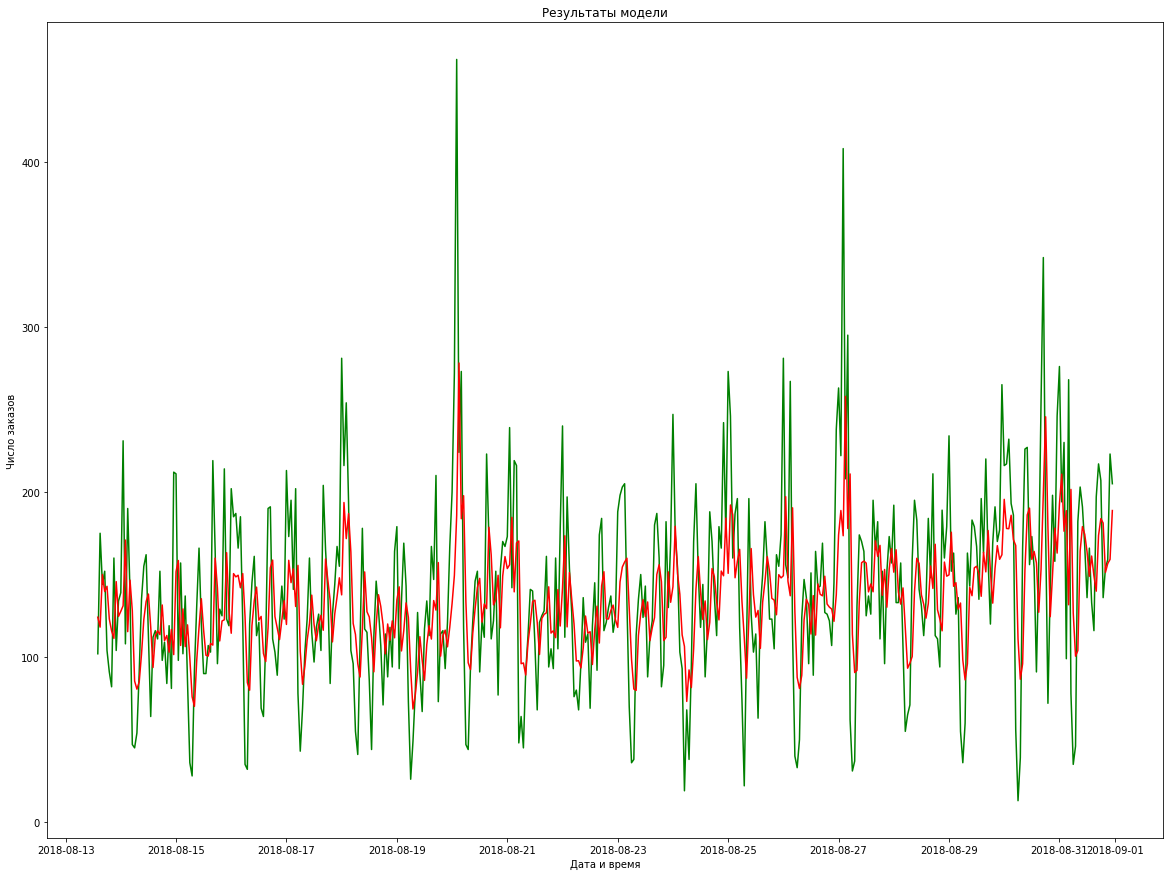

In [31]:
%%time
best_model_dtr = DecisionTreeRegressor(**best_params_DTR)
best_model_dtr.fit(train_features, train_target)
test_predictions_dtr = best_model_dtr.predict(test_features)
print('RMSE:', mean_squared_error(test_target, test_predictions_dtr) ** 0.5)

plt.figure(figsize=(20,15))
plt.plot(test_target.index, 
         test_target, 
         'g-', 
         test_target.index, 
         test_predictions,
         'r-')
plt.title('Результаты модели')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')

## Вывод

* были проверены все 4 модели на тестовой выборке
* лучшее значение метрики RMSE показала модель  CatBoostRegressor - 45.83627474289359